In [1]:
import s3fs

import os
import json
import time
import pickle
import requests
import time
from datetime import datetime
import warnings
# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
from pandas import plotting
from pandas.plotting import radviz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar", leave=False)
import string

import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
import contractions
from contractions import contractions_dict ## pip installed this
from wordcloud import WordCloud, STOPWORDS #pip install
from textblob import TextBlob
!python -m textblob.download_corpora

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec
import multiprocessing as mp

import sklearn
from sklearn.utils import resample # Covert too much Rock! to just enough
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

# Increase screen size.
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 10000)

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2', rc={'figure.figsize':(9,6), 'figure.dpi':100})
# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from yellowbrick.target import ClassBalance

#Pipeline toolset
# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#Model toolset
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#Evaluation toolset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

[nltk_data] Downloading package brown to /Users/Gretzky/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Gretzky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Gretzky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [98]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

In [27]:
z_df = pd.read_csv('zoo.csv')

In [28]:
z_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal_name  214 non-null    object
 1   hair         214 non-null    int64 
 2   feathers     214 non-null    int64 
 3   eggs         214 non-null    int64 
 4   milk         214 non-null    int64 
 5   airborne     214 non-null    int64 
 6   aquatic      214 non-null    int64 
 7   predator     214 non-null    int64 
 8   toothed      214 non-null    int64 
 9   backbone     214 non-null    int64 
 10  breathes     214 non-null    int64 
 11  venomous     214 non-null    int64 
 12  fins         214 non-null    int64 
 13  legs         214 non-null    int64 
 14  tail         214 non-null    int64 
 15  domestic     214 non-null    int64 
 16  catsize      214 non-null    int64 
 17  class_type   214 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 30.2+ KB


In [4]:
z_df.head(20)

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,turtle,0,0,1,0,0,1,0,0,1,1,0,0,4,1,1,1,3
1,chameleon,0,0,1,0,0,0,0,1,1,1,0,0,4,1,1,0,3
2,iguana,0,0,1,0,0,0,1,1,1,1,0,0,4,1,1,1,3
3,lizard,0,0,1,0,0,0,1,1,1,1,0,0,4,1,0,0,3
4,gecko,0,0,1,0,0,0,0,1,1,1,0,0,4,1,1,0,3
5,python,0,0,1,0,0,0,1,1,1,1,1,0,0,1,0,1,3
6,boa,0,0,1,0,0,0,1,1,1,1,0,0,0,1,0,1,3
7,adder,0,0,1,0,0,0,1,1,1,1,1,0,0,1,0,1,3
8,crocodile,0,0,1,0,0,1,1,1,1,1,0,0,4,1,0,1,3
9,alligator,0,0,1,0,0,1,1,1,1,1,0,0,4,1,0,1,3


In [26]:
z_df.describe(include='all')

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.308411,0.186916,0.714953,0.280374,0.247664,0.369159,0.467290,0.532710,0.789720,0.822430,0.107477,0.163551,2.901869,0.677570,0.130841,0.383178,3.257009
std,0.462920,0.390758,0.452495,0.450235,0.432667,0.483709,0.500099,0.500099,0.408463,0.383046,0.310444,0.370735,2.130639,0.468502,0.338017,0.487301,2.058835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,3.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


In [6]:
z_df.class_type.nunique()

7

In [7]:
z_df.class_type.value_counts()
#SOme class imbalance.  Dump amphibians?

1    60
2    40
4    28
3    25
6    25
7    20
5    16
Name: class_type, dtype: int64

In [23]:
z_df[z_df.duplicated()]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type


In [9]:
z_df.isnull().sum()

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
dtype: int64

In [10]:
z_df.isna().sum()

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
dtype: int64

In [29]:
z_df.drop(['animal_name'], axis=1, inplace=True)

In [30]:
z_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   hair        214 non-null    int64
 1   feathers    214 non-null    int64
 2   eggs        214 non-null    int64
 3   milk        214 non-null    int64
 4   airborne    214 non-null    int64
 5   aquatic     214 non-null    int64
 6   predator    214 non-null    int64
 7   toothed     214 non-null    int64
 8   backbone    214 non-null    int64
 9   breathes    214 non-null    int64
 10  venomous    214 non-null    int64
 11  fins        214 non-null    int64
 12  legs        214 non-null    int64
 13  tail        214 non-null    int64
 14  domestic    214 non-null    int64
 15  catsize     214 non-null    int64
 16  class_type  214 non-null    int64
dtypes: int64(17)
memory usage: 28.5 KB


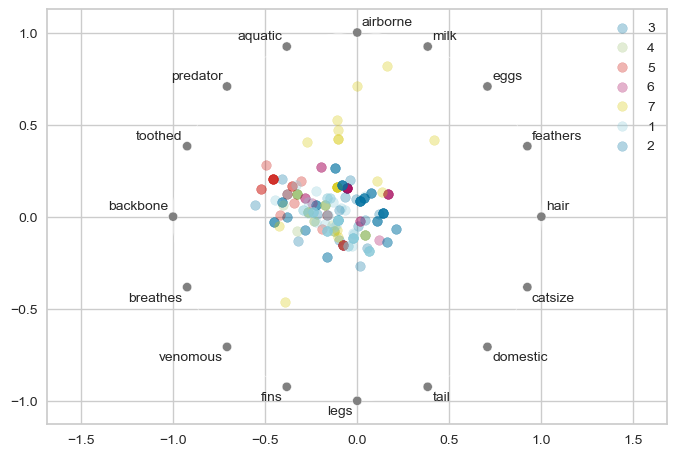

In [31]:
#A visual look at all of the numerical features, mostly scaled (except affin and sentiment).  One big blob.

from pandas.plotting import radviz

def rad_viz(df,labels):
    fig = radviz(df, labels, color=sns.color_palette(), alpha=.3)
    plt.show()


rad_viz(z_df,'class_type')

In [34]:
X = z_df.loc[ : , z_df.columns != 'class_type']
y = z_df['class_type']

In [35]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(171, 16) (171,)
(43, 16) (43,)


In [72]:
from sklearn.feature_selection import RFECV

estimator = RandomForestClassifier()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X, y)

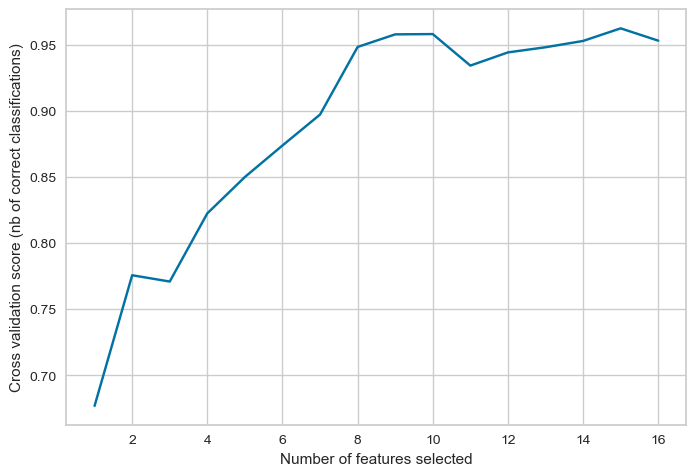

In [73]:
min_features_to_select = 1

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(selector.grid_scores_) + min_features_to_select),
         selector.grid_scores_)
plt.show()

In [40]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=7)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(214, 7)


In [61]:
#LinearSVC is best.  ~10 is the knee in the curve.

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

anova_filter = SelectKBest(f_classif, k=15)
clf = RandomForestClassifier()
anova_svm = make_pipeline(anova_filter, clf)

anova_svm.fit(X_train, y_train)

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         6
           3       1.00      0.50      0.67         6
           4       1.00      1.00      1.00         7
           5       0.50      1.00      0.67         3
           6       0.88      1.00      0.93         7
           7       1.00      0.67      0.80         3

    accuracy                           0.91        43
   macro avg       0.91      0.88      0.87        43
weighted avg       0.94      0.91      0.91        43



In [53]:
X_selected = fs.get_support(indices=False)
print(X_selected)

[ True  True  True  True False False False False  True  True False  True
 False False False False]


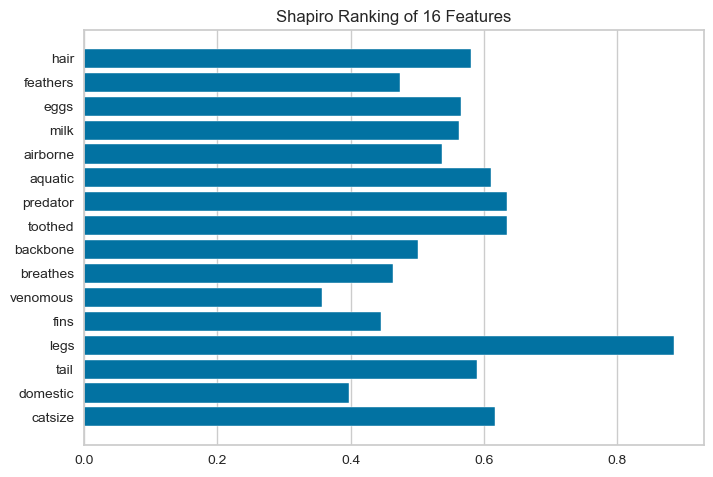

<AxesSubplot:title={'center':'Shapiro Ranking of 16 Features'}>

In [62]:
from yellowbrick.features import Rank1D

visualizer = Rank1D(alogorithm='shapiro')

visualizer.fit(X,y)
visualizer.transform(X)
visualizer.show()

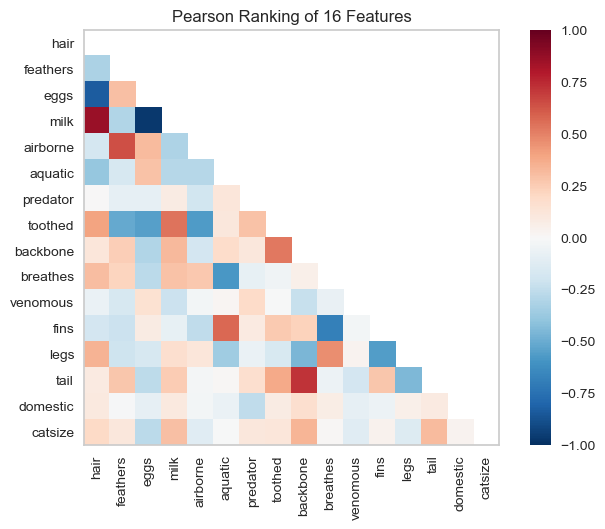

<AxesSubplot:title={'center':'Pearson Ranking of 16 Features'}>

In [63]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(alogorithm='pearson')

visualizer.fit(X,y)
visualizer.transform(X)
visualizer.show()

In [67]:
z2_df = pd.DataFrame((z_df), columns=['hair','feathers','eggs',
                                      'milk','backbone','breathes',
                                      'fins','legs','aquatic','airborne','class_type'])

In [69]:
z2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   hair        214 non-null    int64
 1   feathers    214 non-null    int64
 2   eggs        214 non-null    int64
 3   milk        214 non-null    int64
 4   backbone    214 non-null    int64
 5   breathes    214 non-null    int64
 6   fins        214 non-null    int64
 7   legs        214 non-null    int64
 8   aquatic     214 non-null    int64
 9   airborne    214 non-null    int64
 10  class_type  214 non-null    int64
dtypes: int64(11)
memory usage: 18.5 KB


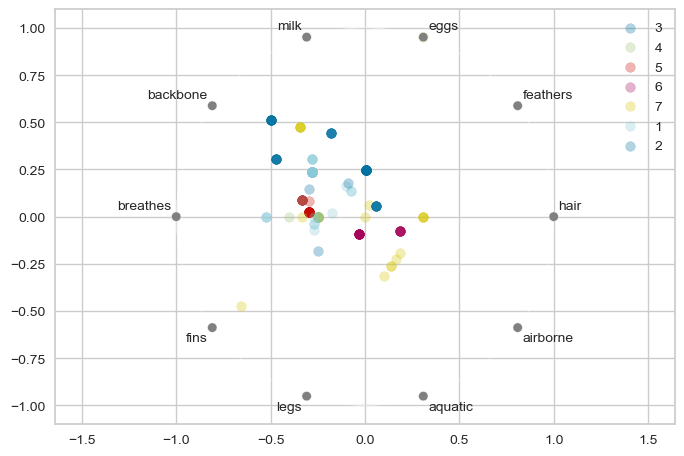

In [68]:
rad_viz(z2_df, 'class_type')

In [89]:
X = z2_df.loc[ : , z2_df.columns != 'class_type']
y = z2_df['class_type']

In [90]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(171, 10) (171,)
(43, 10) (43,)


In [91]:
#make label lists
cat_labels = list(set(z2_df['class_type']))
label_lst = list(set(z2_df['class_type']))

In [92]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [93]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X_test, y_test)
    visualizer.score(X_train, y_train)
    visualizer.show()

In [94]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def a_visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        #('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

    
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [95]:
import matplotlib as plt
from yellowbrick.classifier import confusion_matrix

def conf_matrix(X,y,estimator,label_lst):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        #('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

    # Instantiate the visualizer with the classification model
    confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=label_lst
    )
    plt.tight_layout()

In [97]:
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model,cat_labels)
        a_visualize_model(X, y, model,cat_labels)
        conf_matrix(X, y, model,cat_labels)
    except Exception as exc:
        print(model, traceback.format_exc(), exc)

NameError: name 'traceback' is not defined